# [GD-06] Transformer - Improved Translator
"Going Deeper Node 12. Translator is able to communicate" / 2022. 04. 14 (Thu) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?|챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
|2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?|과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?|주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.

## 1. Environment Setup

In [47]:
import pandas as pd
import numpy as np
import nltk
import gensim
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import re
import os
import io
import time
import random

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/ColabNotebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
csv = data_path + '/Chatbot/ChatbotData.csv'
df1 = pd.read_csv(csv)

In [4]:
data = pd.read_csv(csv)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
len(data)

11823

In [6]:
# Data 전처리

## 결측치
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [7]:
## 아무것도 없는 라벨(0) 지우기
data.drop(['label'], axis=1, inplace=True)

In [8]:
## 중복 데이터 여부 (Question)

data[data.duplicated(['Q'])]

,Q,A
196,고양이 키우고 싶어,가족들과 상의해보세요.
235,공시 준비 힘들어,잘 될 거예요.
1294,돈 벌고 싶어,많이 벌수록 좋아요.
1445,로또 번호 알려줘,알면 제가 하죠.
1481,마음이 울적해,거리를 걸어보세요.
...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.
11658,첫사랑 생각나,지금의 사랑에 충실하세요.
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.


In [9]:
data[data['Q']==data['Q'][11819]]

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.


In [10]:
## 중복 데이터 여부 (Answer)
data[data.duplicated(['A'])]

,Q,A
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.
...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.


In [11]:
data[data['A']==data['A'][4044]]

,Q,A
4044,적금 들까,적금 들 수 있으면 드는 게 좋죠.
4045,적금 들어야 하나,적금 들 수 있으면 드는 게 좋죠.


In [12]:
## 중복 데이터 제거 (Question)

data.drop_duplicates(['Q'], inplace=True)
len(data)

11662

In [13]:
## 중복 데이터 제거 (Answer)

data.drop_duplicates(['A'], inplace=True)
len(data)

7731

In [14]:
## 데이터 정제 시작

# 1. 영문 소문자
# 2. 알파벳, 문장부호, 한글, 숫자
# 3. 문장부호 앞뒤 공백 추가
# 4. 불필요 공백

def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [15]:
questions = [preprocess_sentence(q) for q in data['Q']]
answers = [preprocess_sentence(a) for a in data['A']]

print('Questions :', len(questions))
print('Answers :', len(answers))
print()
for i in range(10):
    print('Q :', questions[i])
    print('A :', answers[i])    
    print()

Questions : 7731
Answers : 7731

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : ppl 심하네
A : 눈살이 찌푸려지죠.

Q : sd카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : sns 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : sns 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : sns보면 나만 빼고 다 행복해보여
A : 자랑하는 자리니까요.

Q : 가끔 궁금해
A : 그 사람도 그럴 거예요.

Q : 가끔은 혼자인게 좋다
A : 혼자를 즐기세요.



In [16]:
# 전처리 결과 저장

encoder_corpus = []
decoder_corpus = []

def make_txt(corpus, lang):
    with open(f'{data_path}/{lang}.txt', 'w') as f:
        for sen in corpus:
            f.write(str(sen) + '\n')
    f.close()
    print(f.name)
    return f.name

In [17]:
enc_path = make_txt(encoder_corpus, lang='kor')
dec_path = make_txt(decoder_corpus, lang='eng')

/content/drive/My Drive/ColabNotebooks/kor.txt
/content/drive/My Drive/ColabNotebooks/eng.txt


In [18]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy==0.5.2 JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [19]:
# Tokenization (Vocab Size = 50000)

from konlpy.tag import Mecab

def tokenize(corpus, vocab_size=50000):
    mecab = Mecab()
    morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                     num_words=vocab_size)
    tokenizer.fit_on_texts(morph)

    tensor = tokenizer.texts_to_sequences(morph)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
        
    return tensor, tokenizer, morph

In [20]:
# Lexical Subsitution

data_wv_path = '/content/drive/My Drive/ColabNotebooks/wv_data'
data_wv_file = data_wv_path + '/ko.bin'

In [21]:
from gensim.models.word2vec import Word2Vec
wv_model = Word2Vec.load(data_wv_file)

In [23]:
import random

sample_sentence = "요즘 어떻게 지내요"
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv_model.wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: 요즘 어떻게 지내요
To: 요즘 언제 지내요 


In [24]:
def lexical_sub(sentence, word2vec):
    import random

    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [25]:
from tqdm import tqdm_notebook

def augment_corpus(src_corpus, tgt_corpus, wv):
    new_src_corpus = []
    new_tgt_corpus = []
    corpus_size = len(src_corpus)
    
    for i in tqdm_notebook(range(corpus_size)):
        old_src = src_corpus[i]
        old_tgt = tgt_corpus[i]

        new_src = lexical_sub(old_src, wv)
        new_tgt = lexical_sub(old_tgt, wv)
        

        if new_src: 
            new_src_corpus.append(new_src)
            new_tgt_corpus.append(old_tgt)
            
        if new_tgt: 
            new_src_corpus.append(old_src)
            new_tgt_corpus.append(new_tgt)

    return new_src_corpus, new_tgt_corpus

In [26]:
_, _, src_corpus_tokenized = tokenize(questions)
_, _, tgt_corpus_tokenized = tokenize(answers)

In [27]:
new_src_corpus, new_tgt_corpus = augment_corpus(src_corpus_tokenized, tgt_corpus_tokenized, wv_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7731 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


In [28]:
print(len(new_src_corpus), len(new_tgt_corpus))

13493 13493


In [29]:
src_corpus_augmented = src_corpus_tokenized + new_src_corpus
tgt_corpus_augmented = tgt_corpus_tokenized + new_tgt_corpus

In [30]:
len(src_corpus_augmented), len(tgt_corpus_augmented)

(21224, 21224)

In [31]:
new_src_corpus_additional, new_tgt_corpus_additional = augment_corpus(src_corpus_augmented, tgt_corpus_augmented, wv_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/21224 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


In [32]:
src_corpus_augmented_2nd = src_corpus_augmented + new_src_corpus_additional
tgt_corpus_augmented_2nd = tgt_corpus_augmented + new_tgt_corpus_additional

In [33]:
len(src_corpus_augmented_2nd), len(tgt_corpus_augmented_2nd)

(58526, 58526)

In [34]:
def build_corpus(que_data, ans_data, max_len=40):
    questions = [preprocess_sentence(q) for q in que_data]
    answers = [preprocess_sentence(a) for a in ans_data]

    print('questions data size :', len(questions))
    print('answers data size :', len(answers))
    print()
    print('Here is the samples from corpus')
    for i in range(10):
        print('Q :', questions[i])
        print('A :', answers[i])    
        print()
    
    que_tensor, que_tokenizer, _ = tokenize(questions)
    ans_tensor, ans_tokenizer, _ = tokenize(answers)
    
    que_corpus = []
    ans_corpus = []
    for q, a in zip(que_tensor, ans_tensor):
        if (len(q) <= max_len) or (len(a) <= max_len):
            que_corpus.append(q)
            ans_corpus.append(a)
    
    print('questions token :', len(que_corpus))
    print('answers token :', len(ans_corpus))
    return que_corpus, ans_corpus, que_tokenizer, ans_tokenizer

In [35]:
que_corpus, ans_corpus, que_tokenizer, ans_tokenizer = build_corpus(src_corpus_augmented_2nd, tgt_corpus_augmented_2nd)

questions data size : 58526
answers data size : 58526

Here is the samples from corpus
Q : 12 시 땡 !
A : 하루 가 또 가 네요 .

Q : 1 지망 학교 떨어졌 어
A : 위로 해 드립니다 .

Q : 3 박 4 일 놀 러 가 고 싶 다
A : 여행 은 언제나 좋 죠 .

Q : ppl 심하 네
A : 눈살 이 찌푸려 지 죠 .

Q : sd 카드 망가졌 어
A : 다시 새로 사 는 게 마음 편해요 .

Q : sns 맞 팔 왜 안 하 지 ㅠㅠ
A : 잘 모르 고 있 을 수 도 있 어요 .

Q : sns 시간 낭비 인 거 아 는데 매일 하 는 중
A : 시간 을 정하 고 해 보 세요 .

Q : sns 보 면 나 만 빼 고 다 행복 해 보여
A : 자랑 하 는 자리 니까요 .

Q : 가끔 궁금 해
A : 그 사람 도 그럴 거 예요 .

Q : 가끔 은 혼자 인 게 좋 다
A : 혼자 를 즐기 세요 .

questions token : 58526
answers token : 58526


In [36]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(que_corpus, ans_corpus, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 57940 enc_val : 586
dec_train : 57940 dec_val : 586


## 2. Modeling

In [37]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [38]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [39]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [42]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [43]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [44]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [45]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

<function matplotlib.pyplot.show>

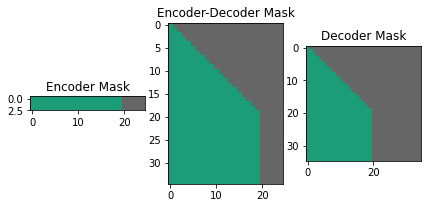

In [48]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Encoder Mask')
ax2.set_title('Encoder-Decoder Mask')
ax3.set_title('Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show

In [49]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    
learning_rate = LearningRateScheduler(512)
oprimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [50]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=len(enc_train),
    tgt_vocab_size=len(dec_train),
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [51]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [52]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [53]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1] 
    gold = tgt[:, 1:]  

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [60]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, str(enc_train.shape), BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

AttributeError: ignored

## 2. Project Retrospective

+ Mecab과 Konlpy를 강제 설치하고, 로드를 시도하였으나 Mecab을 설치하라는(불러오라는) 오류 메시지를 해결하는데 너무 많은 시간이 소요되었다. 버전 이슈로 판단이 되는데, 노드 라이브러리 버전 정보에는 Konlpy에 대한 버전이 특정되어 있지는 않지만 가장 최근까지 진행했던 0.5.2를 강제하니 해결되었다. 앞으로는 각 노드별로 사용되는 모든 라이브러리에 대해 버전 표기가 명기되었으면 한다.

+ 그래서 이번 노드는 기한 내에 데이터 증강까지만 시도하여 보고, 모델링까지 연결하지 못했다. 앞으로는 절대로 LMS를 통해 작업하지 않겠다는 결심이 있었기 때문에 앞으로도 Colab을 통해서 문제를 해결할 수 있도록 계속 노력할 생각이다.

+ enc_train 쪽에서 데이터 변환이 잘못되었거나, 코드에 문제가 있는 것 같다. 과제제출 이후에도 추가 시간을 들여 해결할 생각이다.